In [1]:
#imports
import random as rd
import numpy as np
import math
from scipy.optimize import linprog
import matplotlib.pyplot as plt

In [2]:
def sample(prob): # BS can be done
    r = rd.random();i = 0
    while r > prob[i]:
        r-=prob[i]
        i+=1
    return i

def bernoulli(prob):
    if rd.random() > prob:
        return 1
    return 0

def row_normalize(arr):
    arr = np.array(arr,float)
    for i in range(np.shape(arr)[0]):
        arr[i] = arr[i]/np.sum(arr[i])
    return arr

def steady_state_prob(matrix):
    """
    This function calculates relative throughput from a probability matrix
    :param matrix: the probability matrix
    :return: A list of relative throughput values
    """
    a_list = []
    b_list = []
    for v in matrix:
        a_list.append(1)
        b_list.append(0)
    b_list.append(1)
    A = np.append(np.transpose(matrix) - np.identity(len(matrix)), [a_list], axis=0)
    b = np.transpose(np.array(b_list))
    return np.linalg.solve(np.transpose(A).dot(A), np.transpose(A).dot(b))

In [3]:
# parameters custom
en = 3
ch = 3
pckts = 1
tol = 0.25
P = np.array([[.1, .2, .7],[.5, .3, .2],[.3, .3, .4]])
E = np.array([[.7,.9,.3],[.3,.5,.1],[.4,.1,.05]])
# P = row_normalize(np.random.rand(ch,ch))
# E = np.random.rand(ch,ch)/2
rate = np.array([8.,4.,6.])
lr = 0.01
beta = 5
print(P)
print(E)

[[0.1 0.2 0.7]
 [0.5 0.3 0.2]
 [0.3 0.3 0.4]]
[[0.7  0.9  0.3 ]
 [0.3  0.5  0.1 ]
 [0.4  0.1  0.05]]


In [4]:
lamda = [np.ones(en)/en]
p = []
# p.append(row_normalize(np.random.rand(ch,ch)))
p.append(row_normalize(np.ones((ch,ch))))
chnl = []; b = [] ; enc = []
emp_rate = [0]; emp_err = [0]
chnl.append(rd.randint(0,ch-1))
enc.append(rd.randint(0,en-1))
b.append(np.zeros(pckts))
step = 10
t = 0

In [5]:
T = 1000
sprob = steady_state_prob(p[-1])
temp = np.copy(p[-1])
while t <= T:
    enc.append(sample(lamda[-1]))
    chnl.append(sample(P[chnl[-1]]))
    b.append(np.zeros(pckts))
    for i in range(pckts):
        b[t+1][i] = bernoulli(E[enc[-1]][chnl[-1]])
    tprob = np.zeros(ch)
    ones = np.sum(b[-1])
    for j in range(ch):
        tprob[j] = math.exp(beta*(((pckts-ones)*E[enc[-1]][j])+((ones)*(1-E[enc[-1]][j]))))
    tprob = row_normalize([tprob])[0]
    for i in range(ch):
        for j in range(ch):
            temp[i,j] = temp[i,j] + lr*((sprob[i]*tprob[j]) - temp[i,j])
    temp = row_normalize(temp)

    if t%step == 0:
        p.append(temp)
        sprob = steady_state_prob(p[-1])
        ub = np.sum(E*sprob,axis=1)
        ltemp = linprog(c = -1*rate, A_ub = [ub], b_ub = [tol],A_eq = np.ones((1,en)),b_eq = [1.0],method='revised simplex',options={'tol': 1e-2})
        sprob = np.exp(beta*sprob)
        sprob = row_normalize([sprob])[0]
        temp = np.copy(p[-1])
        lamda.append(ltemp.x)
        emp_err.append(np.dot(ltemp.x,ub))
        emp_rate.append(np.dot(ltemp.x,rate))
        print(t,emp_rate[-1],ltemp.success)
    t+=1

0 6.297470020182322 True
10 6.304713189317727 True
20 6.31088540061943 True
30 6.3191583883217115 True
40 6.324293598596617 True
50 6.330510534748884 True
60 6.331959626298943 True
70 6.3357603526556465 True
80 6.334763365116112 True
90 6.341848503656918 True
100 6.350266606069474 True
110 6.355595116856955 True
120 6.363525779535033 True
130 6.373436966088803 True
140 6.379323843629878 True
150 6.38596404908063 True
160 6.395752265345516 True
170 6.40481681118834 True
180 6.405457264547987 True
190 6.408479547856332 True
200 6.4135540925956995 True
210 6.416742797938927 True
220 6.409456320152076 True
230 6.405872099386851 True
240 6.411772779888755 True
250 6.413810686147679 True
260 6.413104361358594 True
270 6.4209058367179805 True
280 6.423358320331735 True
290 6.424800149662361 True
300 6.417080309763572 True
310 6.423391858109814 True
320 6.4309018303466186 True
330 6.435376891745632 True
340 6.438174863084551 True
350 6.436502211849147 True
360 6.44257792516527 True
370 6.44174

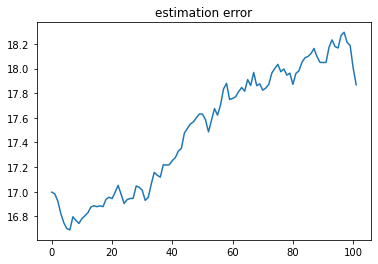

In [6]:
err = []; s = np.shape(P)[0]*np.shape(P)[1]
for i in p:
    err.append(np.sqrt(np.sum(np.square(P-i))/s)*100)
plt.plot(err)
plt.title('estimation error')
plt.show()

In [7]:
print(p[-1])
print(P)
print(lamda[-1])
print(sprob)

[[0.20890614 0.3639813  0.42711255]
 [0.19321652 0.36520268 0.4415808 ]
 [0.1928769  0.36389734 0.44322577]]
[[0.1 0.2 0.7]
 [0.5 0.3 0.2]
 [0.3 0.3 0.4]]
[0.24581619 0.         0.75418381]
[0.14936713 0.34641276 0.50422011]


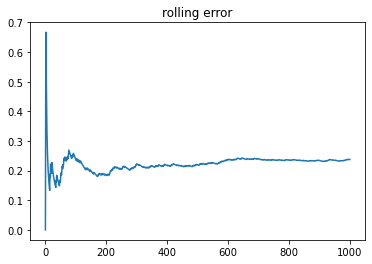

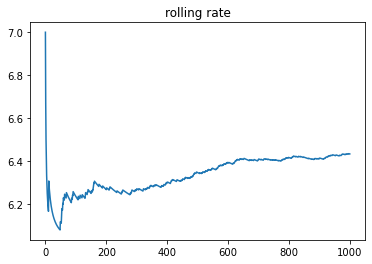

In [8]:
error_plot = pckts - np.sum(b,axis=1)
for i in range(1,len(error_plot)):
    error_plot[i] += (error_plot[i-1]*(i-1))
    error_plot[i] =error_plot[i]/i
plt.plot(error_plot[1:])
plt.title('rolling error')
plt.show()
rate_plot = [0]
for i in range(1,len(b)):
    rate_plot.append((rate_plot[i-1]*(i-1))+rate[enc[i]])
    rate_plot[i] =rate_plot[i]/i
plt.plot(rate_plot[2:])
plt.title('rolling rate')
plt.show()

In [9]:
print(rate_plot[-1],error_plot[-1])

6.433566433566436 0.23776223776223773


In [10]:
ub = np.sum(E*steady_state_prob(P),axis=1)
ltemp = linprog(c = -1*rate, A_ub = [ub], b_ub = [tol],A_eq = np.ones((1,en)),b_eq = [1.0],method='simplex')
print(steady_state_prob(P))
print(np.dot(ltemp.x,rate), np.sum(ltemp.x),ltemp.con, ltemp.success, np.dot(ltemp.x,ub))

[0.29508197 0.2704918  0.43442623]
6.402378592666005 0.9999999999999999 [1.11022302e-16] True 0.25


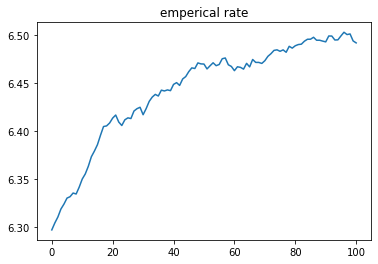

6.491632382582047


In [12]:
# plt.plot(emp_err[1:])
# plt.title('emperical error')
# plt.show()
plt.plot(emp_rate[1:])
plt.title('emperical rate')
plt.show()
print(emp_rate[-1])